# CORDEX.be II evaluation 


In [10]:
%matplotlib inline

import xarray as xr
from datatree import DataTree, map_over_subtree
from pathlib import Path
import pandas as pd
from dask.diagnostics import ProgressBar
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import xclim

import cartopy.crs as ccrs
import valenspy as vp
from valenspy.diagnostic.visualizations import _add_features
from valenspy.diagnostic.functions import root_mean_square_error
from valenspy.input.unit_converter import CORDEX_VARIABLES


git_dir = Path(os.popen("git rev-parse --show-toplevel").read().strip())

## User options

In [11]:
# Load data options
variables = ["tas", "pr", "tasmin", "tasmax"]
period = [1980, 2019]

#Unit handeling - choose the units for the output
unit_dict = {
    "tas": "C",
    "tasmax": "C",
    "tasmin": "C",
    "pr": "mm/day"
}

# Plotting options - to be moved to a seperate "config" file
## Use the seaborn-v0_8-deep style?

mpl.rc('axes',edgecolor='grey')
mpl.rc('axes',labelcolor='dimgrey')
mpl.rc('axes',titlesize=14)
mpl.rc('axes',labelsize=10)
mpl.rc('axes', titlelocation="right")
mpl.rc('xtick',color='dimgrey')
mpl.rc('xtick',labelsize=10)
mpl.rc('ytick',color='dimgrey')
mpl.rc('ytick',labelsize=10)
mpl.rc('legend',fontsize='large')
mpl.rc('legend',frameon=False)
mpl.rc('text',color='dimgrey')
mpl.rc('figure', titlesize=16)


## Specify colors for the specific models
color_dict = {
    "/RCM/ERA5/ALARO1_SFX"          : "tab:blue",
    "/RCM/ERA5/CCLM6-0-1-URB-ESG"   : "tab:orange",
    "/RCM/ERA5/MAR"                 : "tab:green",
    "/obs/CLIMATE_GRID"             : "black"
}

d_cmap_diverging = { "tas": 'RdBu_r', "tasmax":'RdBu_r', "tasmin":'RdBu_r', "pr": 'BrBG' }
d_cmap_sequential = {"tas": 'YlOrRd', "tasmax": 'YlOrRd', "tasmin": 'YlOrRd', "pr": 'YlGnBu' }

#Diagnostic options
## Model2Self
do_AnnualCycle = {
    "compute": True,
    "variables" : variables,
}
do_TimeSeries = {
    "compute": True,
    "variables" : variables,
    "periods": [["1997-06-01", "1997-08-31"], ["2003-07-20", "2003-08-20"]]
}
do_TimeSeriesUkkel = {
    "compute": True,
    "variables" : variables,
    "periods": [["1997-06-01", "1997-08-31"]]
}
do_Trends = {
    "compute": True,
    "variables" : variables
}
do_SpatialMean = {
    "compute": True,
    "variables" : variables,
    "reference": "/obs/CLIMATE_GRID",
    "seasons" : ["All", "DJF", "MAM", "JJA", "SON"]
}

## Model2Ref
do_SpatialBias = {
    "compute": True,
    "variables" : variables,
    "reference": "/obs/CLIMATE_GRID",
    "seasons" : ["All" , "DJF", "MAM", "JJA", "SON"]
}

#Add xclim variables

## STEP 1: Load the data

In [12]:
manager = vp.InputManager(machine="hortense")

# ALARO (Using the catalog and the variables userinput)

df_alaro = pd.read_csv(git_dir/"CORDEX_eval_scripts/catalog.csv")
df_alaro = df_alaro[df_alaro['frequency'] == 'day']
df_alaro = df_alaro[df_alaro['variable_id'].isin(variables)]
df_alaro

#Load all the paths in the df into one xarray dataset
ds_alaro = xr.open_mfdataset(df_alaro['path'].values, decode_coords='all', chunks="auto")
ds_alaro

## (Requires user adjustment)
# COSMO (Using the input manager - currently variables loaded manually)
experiment      = "CB2_CCLM_BEL28_ERA5_evaluation"
ds_cclm_tas     = manager.load_data("CCLM", ["tas"], freq="daily", path_identifiers=[experiment, "mean"])
ds_cclm_tasmax  = manager.load_data("CCLM", ["tas"], freq="daily", path_identifiers=[experiment, "max"]).rename({'tas':'tasmax'})
ds_cclm_tasmin  = manager.load_data("CCLM", ["tas"], freq="daily", path_identifiers=[experiment, "min"]).rename({'tas':'tasmin'})
ds_cclm_pr      = manager.load_data("CCLM", ["pr"], freq="daily", path_identifiers=[experiment, "sum"])
ds_cclm         = xr.merge([ds_cclm_tas, ds_cclm_pr, ds_cclm_tasmax, ds_cclm_tasmin])

# adjust the time from 11:30 to 12:00 to make xclim work. 
new_time = ds_cclm.tas.time.astype('datetime64[D]') + np.timedelta64(12, 'h')
ds_cclm = ds_cclm.assign_coords(time=new_time)

del ds_cclm_tas , ds_cclm_pr, ds_cclm_tasmax, ds_cclm_tasmin
# ds_cclm = ds_cclm_tas

## (Requires user adjustment)
# MAR (Placeholder for MAR data - for plotting purposes)
ds_mar = ds_alaro

# Observational data
## CLIMATE_GRID (Regridded data)

ds_ref = manager.load_data("CLIMATE_GRID", variables, path_identifiers=["regridded"])

File paths found:
/dodrio/scratch/projects/2022_200/project_output/rcs/CORDEXBE2/postprocessing/CB2_CCLM_BEL28_ERA5_evaluation/T_2M/daily/T_2M_daily_mean_2015.nc
/dodrio/scratch/projects/2022_200/project_output/rcs/CORDEXBE2/postprocessing/CB2_CCLM_BEL28_ERA5_evaluation/T_2M/daily/T_2M_daily_mean_1992.nc
/dodrio/scratch/projects/2022_200/project_output/rcs/CORDEXBE2/postprocessing/CB2_CCLM_BEL28_ERA5_evaluation/T_2M/daily/T_2M_daily_mean_1995.nc
/dodrio/scratch/projects/2022_200/project_output/rcs/CORDEXBE2/postprocessing/CB2_CCLM_BEL28_ERA5_evaluation/T_2M/daily/T_2M_daily_mean_1993.nc
/dodrio/scratch/projects/2022_200/project_output/rcs/CORDEXBE2/postprocessing/CB2_CCLM_BEL28_ERA5_evaluation/T_2M/daily/T_2M_daily_mean_1983.nc
/dodrio/scratch/projects/2022_200/project_output/rcs/CORDEXBE2/postprocessing/CB2_CCLM_BEL28_ERA5_evaluation/T_2M/daily/T_2M_daily_mean_2004.nc
/dodrio/scratch/projects/2022_200/project_output/rcs/CORDEXBE2/postprocessing/CB2_CCLM_BEL28_ERA5_evaluation/T_2M/dail

/tmp/ipykernel_3816412/2952987630.py:24: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  new_time = ds_cclm.tas.time.astype('datetime64[D]') + np.timedelta64(12, 'h')


File paths found:
/dodrio/scratch/projects/2022_200/external/climate_grid/regridded/latlon_5km/TEMP_MAX_CLIMATE_GRID_1954_2023_daily_latlon_5km.nc
/dodrio/scratch/projects/2022_200/external/climate_grid/regridded/latlon_5km/PRECIP_QUANTITY_CLIMATE_GRID_1951_2023_daily_latlon_5km.nc
/dodrio/scratch/projects/2022_200/external/climate_grid/regridded/latlon_5km/TEMP_MIN_CLIMATE_GRID_1954_2023_daily_latlon_5km.nc
/dodrio/scratch/projects/2022_200/external/climate_grid/regridded/latlon_5km/TEMP_AVG_CLIMATE_GRID_1954_2023_daily_latlon_5km.nc
The file is ValEnsPy CF compliant.
100.00% of the variables are ValEnsPy CF compliant
ValEnsPy CF compliant: ['pr', 'tas', 'tasmax', 'tasmin']


### Create a DataTree object

In [4]:
## (Requires user adjustment)
data_dict = {
    "RCM/ERA5/ALARO1_SFX": ds_alaro,
    "RCM/ERA5/CCLM6-0-1-URB-ESG": ds_cclm, 
    "RCM/ERA5/MAR": ds_mar,
    "obs/CLIMATE_GRID": ds_ref
}

dt = DataTree.from_dict(data_dict)

## STEP 2: Preprocessing the data

### CCLM xclim to be fixed - freq attribute?

In [5]:
#To be added in valenspy (including a non map_over_subtree version) - which is basically a wrapper over xclim.units.convert_units_to
@map_over_subtree
def convert_units_to(ds, var, target_unit, context="infer"):
    if var in ds:
        ds = ds.copy()
        ds[var] = xclim.units.convert_units_to(ds[var], target_unit, context=context)
    return ds

In [6]:
#Move to valenspy when happy with the implementation
#How to deal with indicators that require multiple variables?s
@map_over_subtree
def xclim_indicator(ds, indicator, vars, **kwargs):
    if isinstance(vars, str):
        return indicator(ds[vars], **kwargs).to_dataset()
    elif isinstance(vars, list): #Order is important!
        data_arrays = [ds[var] for var in vars]
        return indicator(*data_arrays, **kwargs).to_dataset()


In [16]:
#Regid to CLIMATE_GRID
dt["RCM"] = dt["RCM"].map_over_subtree(vp.remap_xesmf, dt.obs.CLIMATE_GRID.to_dataset(), method="conservative", regridding_kwargs={"keep_attrs": True})

#Select the time period from period[0] to period[1] (inclusive)
dt = dt.sel(time=slice(f"{period[0]}-01-01", f"{period[1]}-12-31"))

#Unit conversion to the desired units
for var, unit in unit_dict.items():
    dt = convert_units_to(dt, var, unit)

In [17]:
#Working but requries CCLM data fix
# Location is important! Before or after regridding? Before or after unit conversion? Best before!
dt_tnn = xclim_indicator(dt, xclim.indicators.cf.tnn, vars="tas", freq="YS")
dt_txx = xclim_indicator(dt, xclim.indicators.cf.txx, vars="tasmax", freq="YS")
dt_max_1day_precipitation_amount = xclim_indicator(dt, xclim.atmos.max_1day_precipitation_amount, vars="pr", freq="YS")

xclim_dt_dict = {
     "tnn": dt_tnn,
     "txx": dt_txx,
     "rx1day": dt_max_1day_precipitation_amount
 }

/dodrio/scratch/projects/2022_200/project_output/rcs/software/miniconda3/envs/valenspy_xesmf/lib/python3.10/site-packages/xclim/core/cfchecks.py:79: UserWarning: Variable has a non-conforming cell_methods: Got `area: time: mean`, which do not include the expected `time: minimum`.
  _check_cell_methods(
/dodrio/scratch/projects/2022_200/project_output/rcs/software/miniconda3/envs/valenspy_xesmf/lib/python3.10/site-packages/xclim/core/cfchecks.py:79: UserWarning: Variable has a non-conforming cell_methods: Got `time: point`, which do not include the expected `time: minimum`.
  _check_cell_methods(
/dodrio/scratch/projects/2022_200/project_output/rcs/software/miniconda3/envs/valenspy_xesmf/lib/python3.10/site-packages/xclim/core/cfchecks.py:79: UserWarning: Variable has a non-conforming cell_methods: Got `area: time: mean`, which do not include the expected `time: minimum`.
  _check_cell_methods(
/dodrio/scratch/projects/2022_200/project_output/rcs/software/miniconda3/envs/valenspy_xesmf/

## STEP 3: Diagnostics

In [13]:
from valenspy.diagnostic import AnnualCycle
from valenspy.diagnostic import TimeSeriesSpatialMean
from valenspy.diagnostic import TimeSeriesTrendSpatialMean
from valenspy.diagnostic import SpatialTimeMean
from valenspy.diagnostic import SpatialBias

### Model2Self

#### Annual Cycle

[########################################] | 100% Completed | 194.40 s
[########################################] | 100% Completed | 51.93 s
[########################################] | 100% Completed | 181.75 s
[########################################] | 100% Completed | 25.60 s


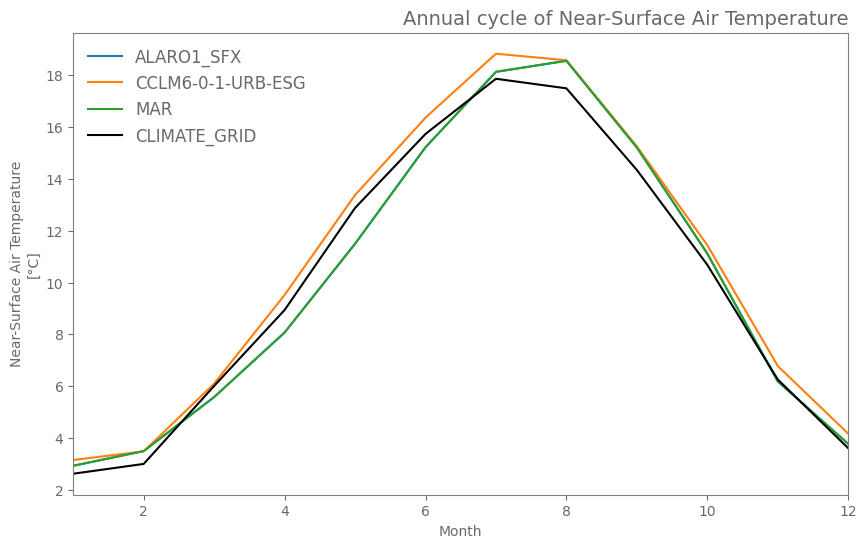

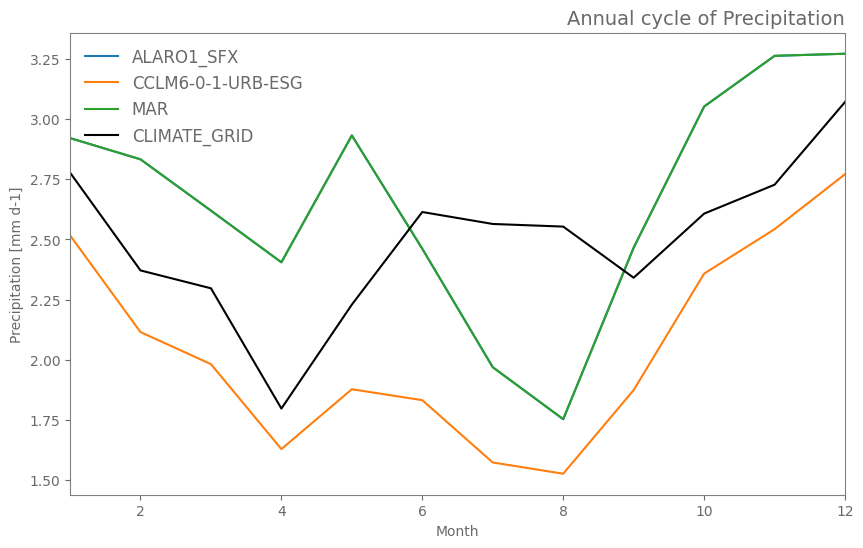

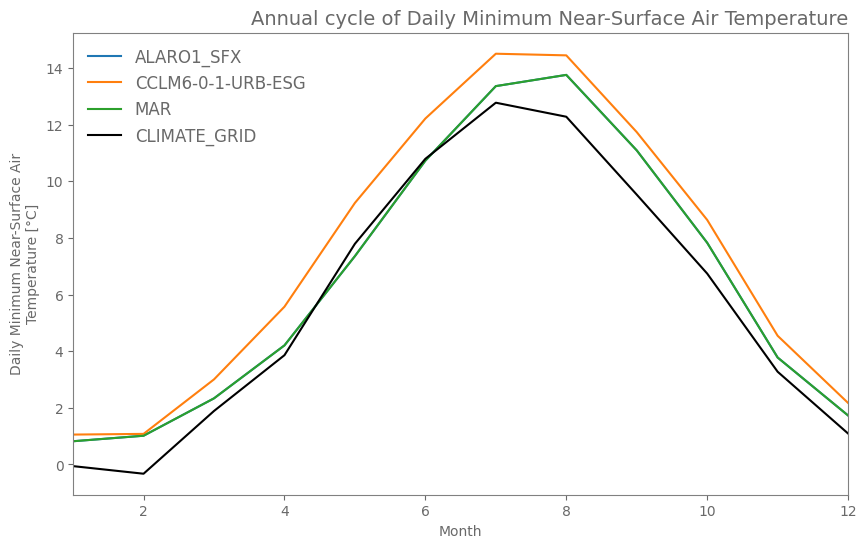

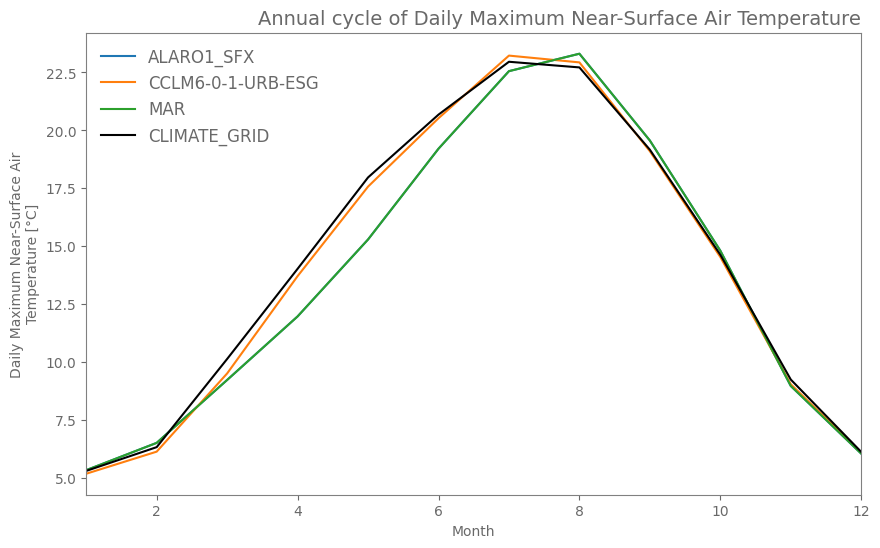

In [13]:
if do_AnnualCycle["compute"]:
    with ProgressBar():
        dt_annual_cycle = AnnualCycle(dt).compute()

    for var in do_AnnualCycle["variables"]:
        fig, ax = plt.subplots(figsize=(10, 6))
        AnnualCycle.plot_dt(dt_annual_cycle, var=var, ax=ax, label="name", colors=color_dict)
        plt.title(f"Annual cycle of {CORDEX_VARIABLES[var]['long_name']}")
        plt.legend()
        ax.set_xlim(1,12)
        plt.savefig(git_dir / f"CORDEX_eval_scripts/plots/{var}_bel_mean_annual_cycle.png")

#### TimeSeries

[########################################] | 100% Completed | 2.23 sms
[########################################] | 100% Completed | 813.40 ms
[########################################] | 100% Completed | 929.48 ms
[########################################] | 100% Completed | 18.96 s
[########################################] | 100% Completed | 2.08 sms
[########################################] | 100% Completed | 1.22 sms
[########################################] | 100% Completed | 622.72 ms
[########################################] | 100% Completed | 20.35 s


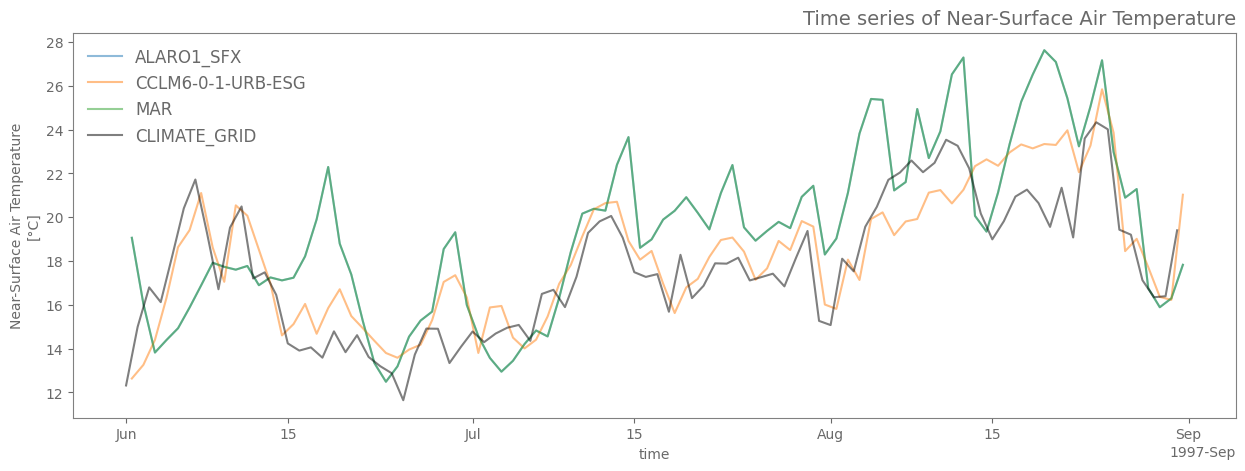

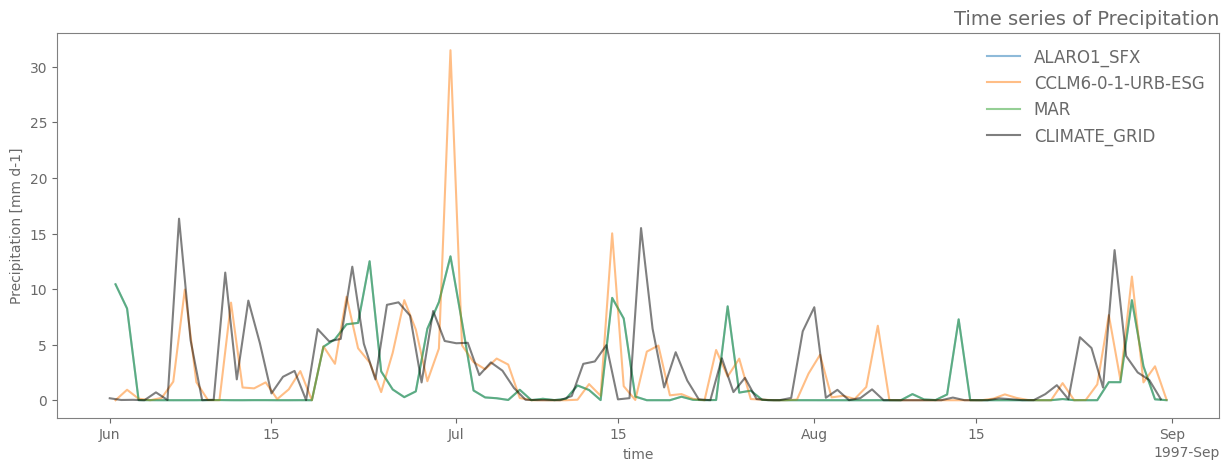

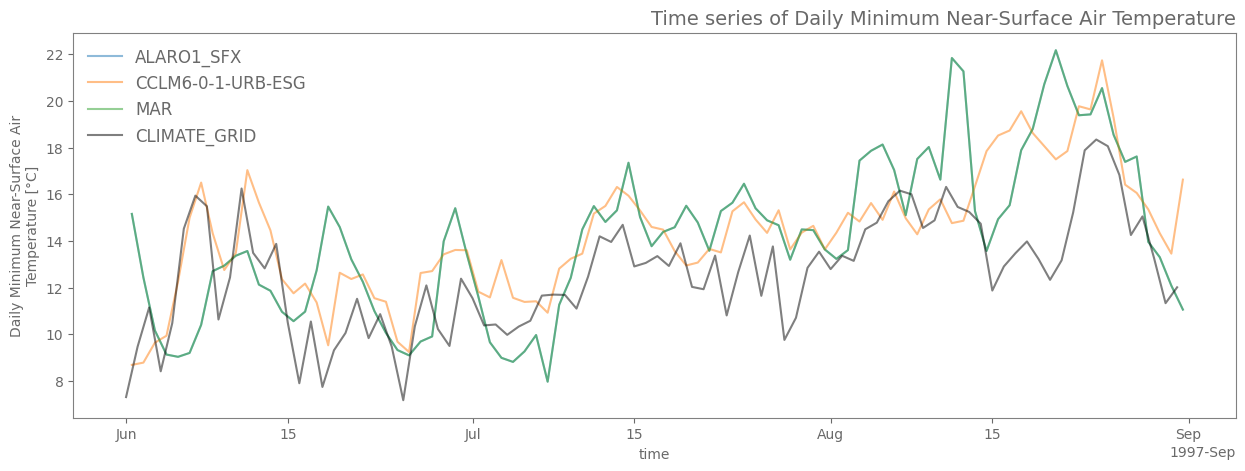

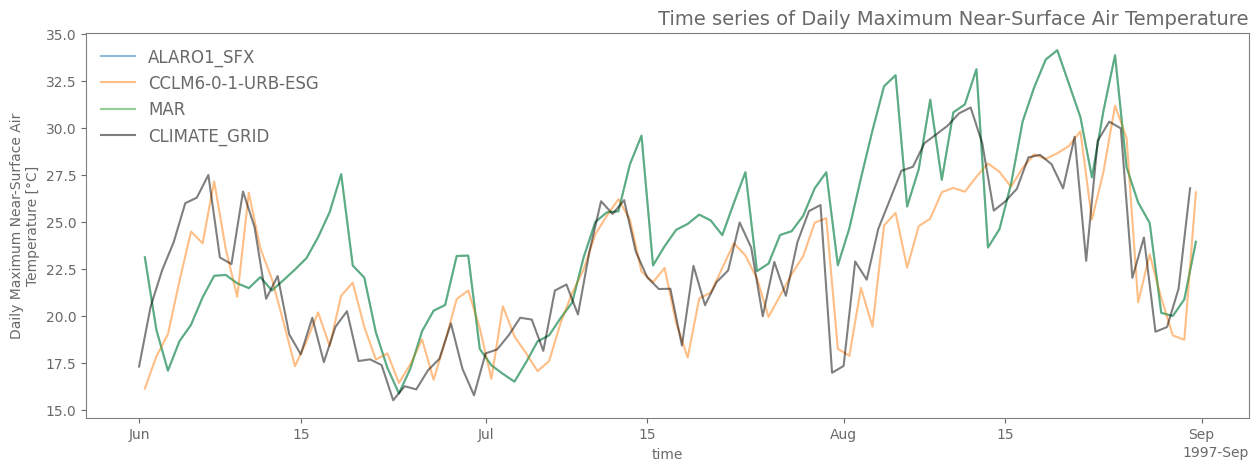

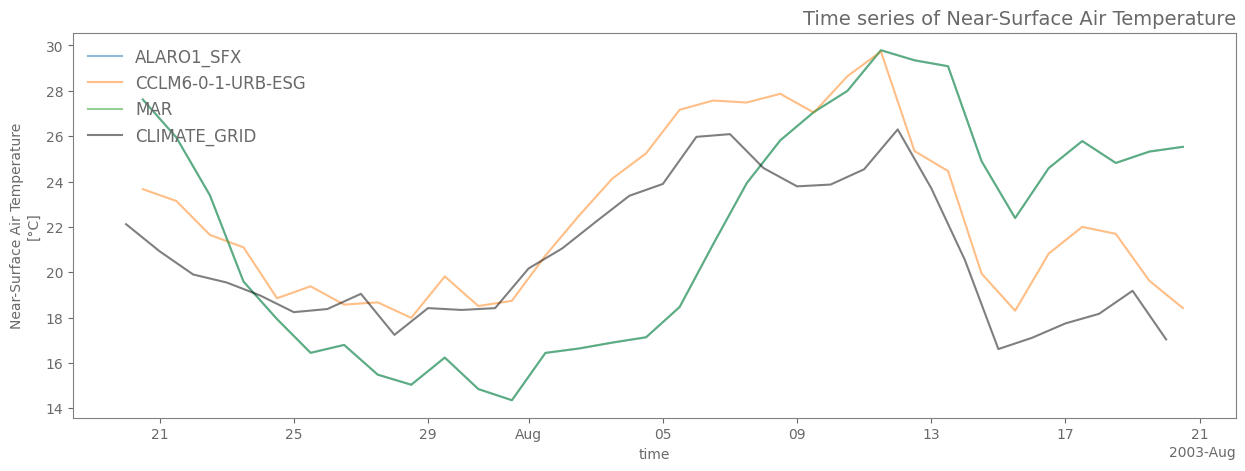

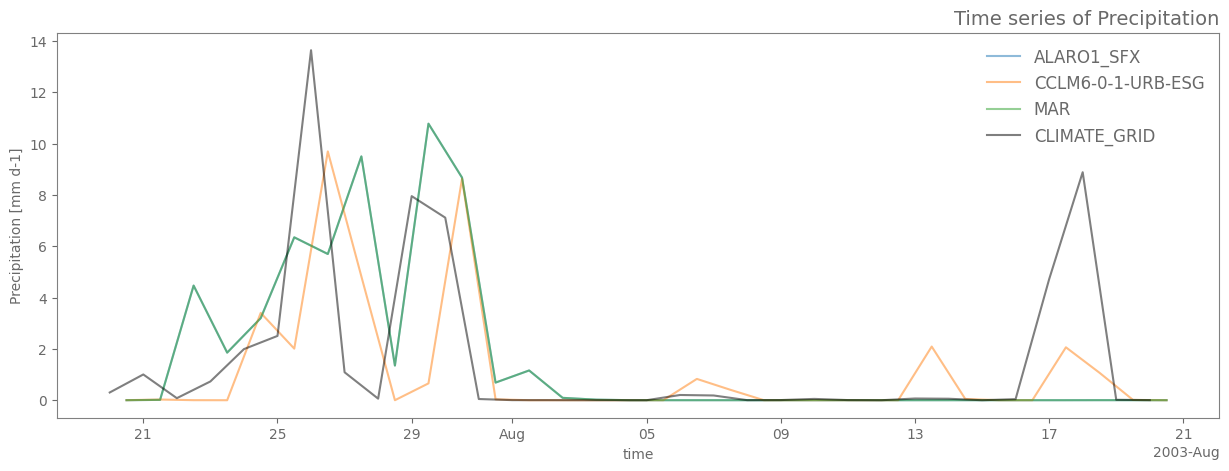

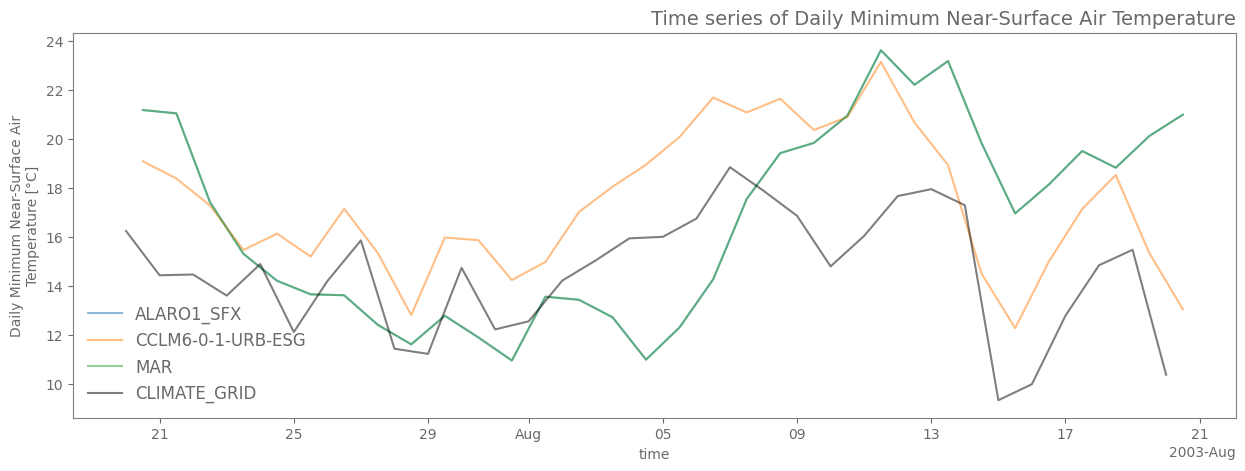

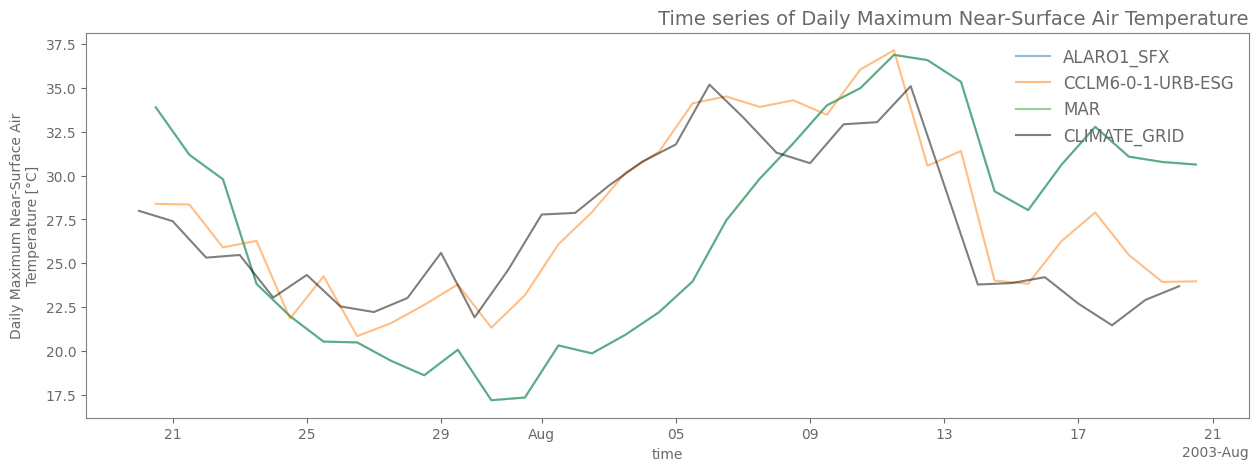

In [15]:
if do_TimeSeries["compute"]:
    for period in do_TimeSeries["periods"]:
        if period == "All":
            dt_time_series = dt
        else:
            dt_time_series = dt.sel(time=slice(period[0], period[1]))
        with ProgressBar():
            dt_time_series = TimeSeriesSpatialMean(dt_time_series).compute()

        for var in do_TimeSeries["variables"]:
            fig, ax = plt.subplots(figsize=(15, 5))
            TimeSeriesSpatialMean.plot_dt(dt_time_series, var=var, ax=ax, label="name", colors=color_dict, alpha=0.5)
            plt.title(f"Time series of {CORDEX_VARIABLES[var]['long_name']}")
            plt.legend()
            plt.savefig(git_dir / f"CORDEX_eval_scripts/plots/{var}_time_series_bel_mean_{period}.png")

### Xclim variables and derivatives

Computing TimeSeriesSpatialMean for tnn
[########################################] | 100% Completed | 27.38 s
[########################################] | 100% Completed | 12.47 ss
[########################################] | 100% Completed | 37.14 s
[########################################] | 100% Completed | 5.03 sms
Computing TimeSeriesSpatialMean for txx
[########################################] | 100% Completed | 26.84 s
[########################################] | 100% Completed | 9.25 sms
[########################################] | 100% Completed | 27.14 s
[########################################] | 100% Completed | 8.58 sms
Computing TimeSeriesSpatialMean for rx1day
[########################################] | 100% Completed | 29.50 s
[########################################] | 100% Completed | 12.11 ss
[########################################] | 100% Completed | 29.61 s
[########################################] | 100% Completed | 7.75 ss


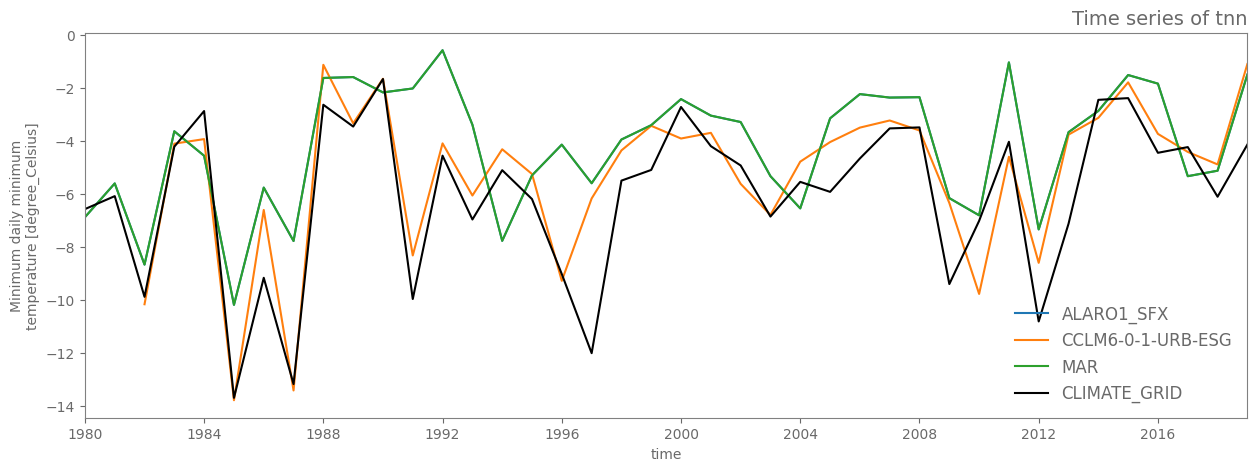

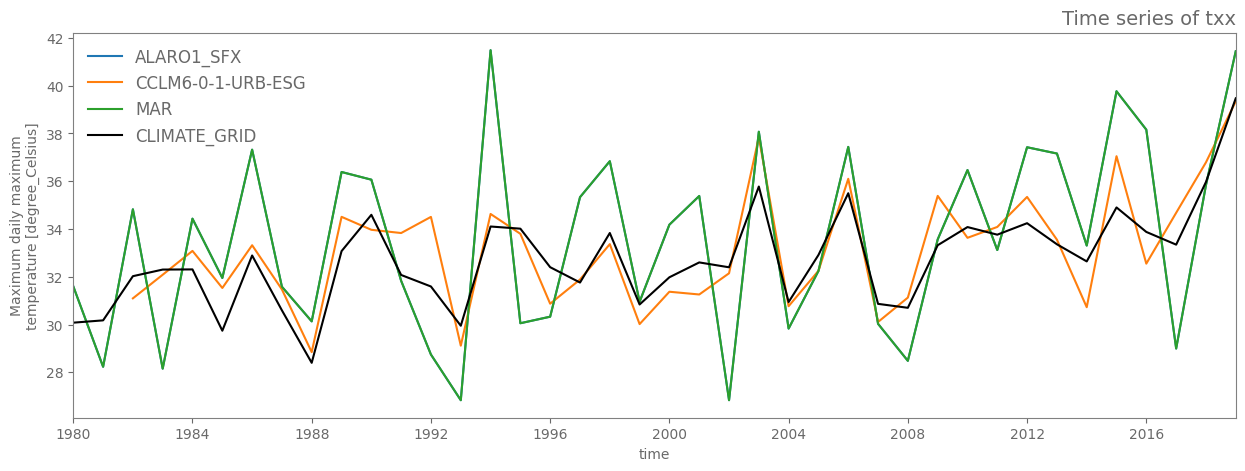

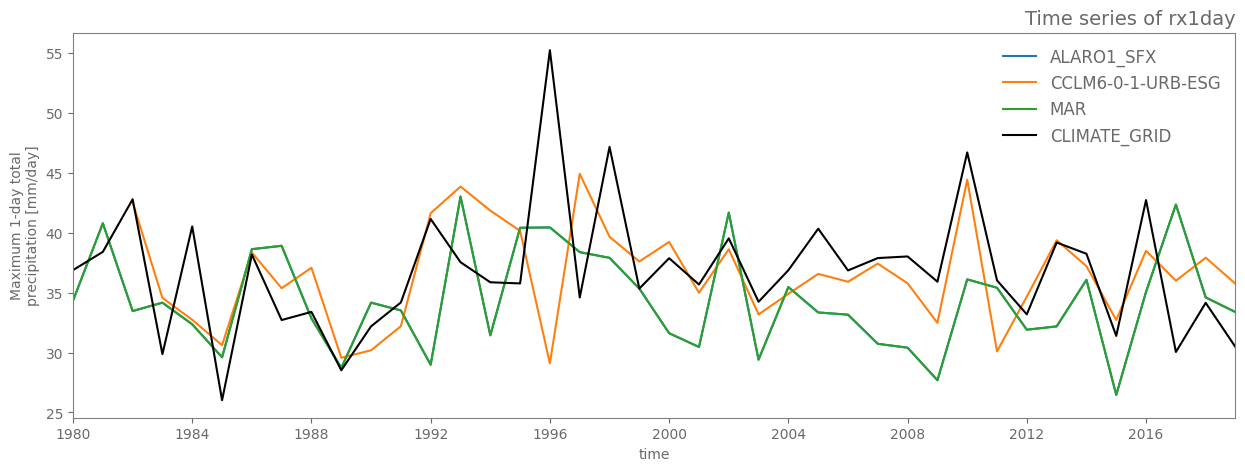

In [25]:
for var, dt_xclim in xclim_dt_dict.items():
     with ProgressBar():
         print(f"Computing TimeSeriesSpatialMean for {var}")
         dt_time_series = TimeSeriesSpatialMean(dt_xclim).compute()

     fig, ax = plt.subplots(figsize=(15, 5))
     TimeSeriesSpatialMean.plot_dt(dt_time_series, var=var, ax=ax, label="name", colors=color_dict)
     plt.title(f"Time series of {var}")
     plt.legend()
     ax.set_xlim(dt_time_series.leaves[0].time.min(), dt_time_series.leaves[0].time.max())
     plt.savefig(git_dir / f"CORDEX_eval_scripts/plots/{var}_time_series_bel_mean.png")

#### TimeSeries (Ukkel)

[########################################] | 100% Completed | 31.90 s
[########################################] | 100% Completed | 9.21 ss
[########################################] | 100% Completed | 29.70 s
[########################################] | 100% Completed | 1.04 sms
[########################################] | 100% Completed | 28.21 s
[########################################] | 100% Completed | 9.12 sms
[########################################] | 100% Completed | 31.51 s
[########################################] | 100% Completed | 1.22 sms


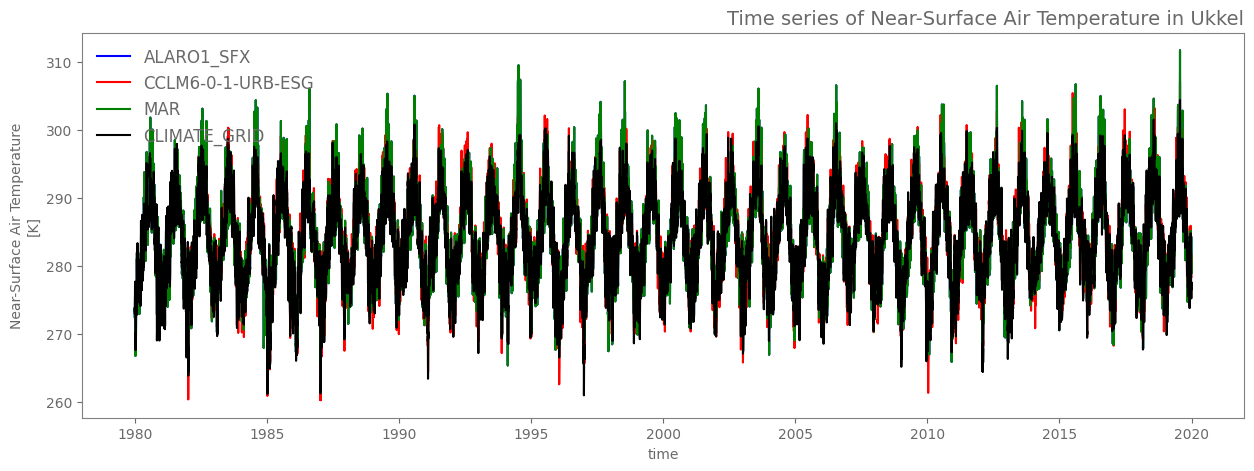

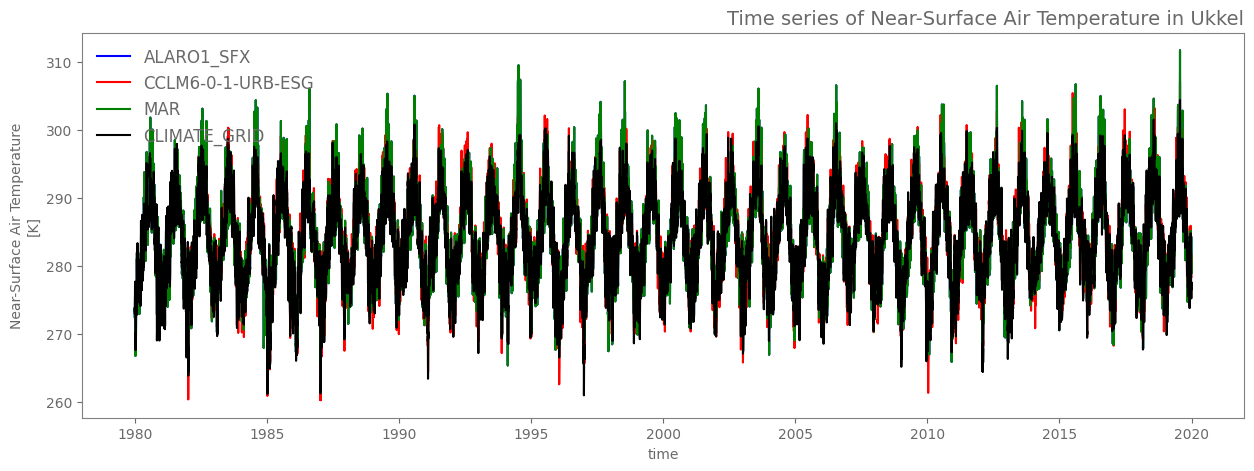

In [ ]:
if do_TimeSeriesUkkel["compute"]:
    Ukkel = (4.37, 50.79)
    dt_ukkel_hw = dt.map_over_subtree(vp.select_point, Ukkel[0], Ukkel[1])
    for period in do_TimeSeries["periods"]:
        if period == "All":
            dt_time_series = dt_ukkel_hw
        else:
            dt_time_series_uccle = dt_ukkel_hw.sel(time=slice(period[0], period[1]))
        
        with ProgressBar():
            print(f"Computing time series for {period}")
            dt_time_series_uccle = TimeSeriesSpatialMean(dt_time_series).compute()

        for var in do_TimeSeries["variables"]:
            fig, ax = plt.subplots(figsize=(15, 5))
            TimeSeriesSpatialMean.plot_dt(dt_time_series_uccle, var=var, ax=ax, label="name", colors=color_dict, alpha=0.5)
            plt.title(f"Time series of {CORDEX_VARIABLES[var]['long_name']} in Ukkel")
            plt.legend()
            ax.set_xlim(dt_time_series_uccle.time.min(), dt_time_series_uccle.time.max())
            plt.tight_layout()
            plt.savefig(git_dir / f"CORDEX_eval_scripts/plots/{var}_time_series_ukkel_{period}.png")

Trends

[########################################] | 100% Completed | 30.67 s
[########################################] | 100% Completed | 10.65 s
[########################################] | 100% Completed | 30.20 s
[########################################] | 100% Completed | 1.01 sms


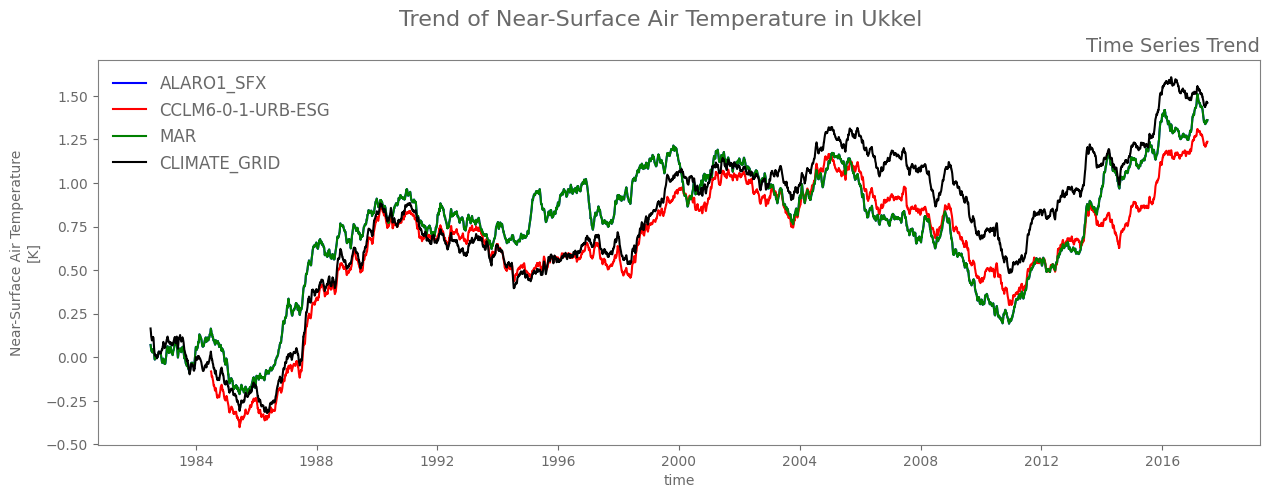

In [ ]:
if do_Trends["compute"]:
    years=5
    window_size = 366*years # 5 years
    Ukkel = (4.37, 50.79)
    dt_Ukkel = dt.map_over_subtree(vp.select_point, Ukkel[0], Ukkel[1])
    dt_Ukkel = dt_Ukkel - dt_Ukkel.sel(time=slice("1980-01-01", "1985-12-31")).mean("time")
    with ProgressBar():
        dt_trends = TimeSeriesTrendSpatialMean(dt_Ukkel, window_size=window_size).compute()

    for var in do_Trends["variables"]:
        fig, ax = plt.subplots(figsize=(15, 5))
        TimeSeriesTrendSpatialMean.plot_dt(dt_trends, var=var, ax=ax, label="name", colors=color_dict)
        plt.legend()
        ax.set_xlim(dt_trends.time.min(), dt_trends.time.max())
        plt.title(f"Trend of {CORDEX_VARIABLES[var]['long_name']} in Ukkel")
        plt.savefig(git_dir / f"CORDEX_eval_scripts/plots/{var}_trend_ukkel_window_{years}y.png")

### Spatial Mean

Computing spatial mean for All
[########################################] | 100% Completed | 111.95 s
[########################################] | 100% Completed | 36.15 s
[########################################] | 100% Completed | 146.98 s
[########################################] | 100% Completed | 17.87 s


/dodrio/scratch/projects/2022_200/project_output/rcs/software/miniconda3/envs/valenspy_xesmf/lib/python3.10/site-packages/cartopy/mpl/feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/dodrio/scratch/projects/2022_200/project_output/rcs/software/miniconda3/envs/valenspy_xesmf/lib/python3.10/site-packages/cartopy/mpl/feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/dodrio/scratch/projects/2022_200/project_output/rcs/software/miniconda3/envs/valenspy_xesmf/lib/python3.10/site-packages/cartopy/mpl/feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/dodrio/scratch/projects/2022_200/project_output/rcs/software/miniconda3/envs/valenspy_xesmf/lib/python

Computing spatial mean for DJF
[########################################] | 100% Completed | 78.89 s
[########################################] | 100% Completed | 37.31 s
[########################################] | 100% Completed | 95.54 s
[########################################] | 100% Completed | 16.64 s


/dodrio/scratch/projects/2022_200/project_output/rcs/software/miniconda3/envs/valenspy_xesmf/lib/python3.10/site-packages/cartopy/mpl/feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/dodrio/scratch/projects/2022_200/project_output/rcs/software/miniconda3/envs/valenspy_xesmf/lib/python3.10/site-packages/cartopy/mpl/feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/dodrio/scratch/projects/2022_200/project_output/rcs/software/miniconda3/envs/valenspy_xesmf/lib/python3.10/site-packages/cartopy/mpl/feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/dodrio/scratch/projects/2022_200/project_output/rcs/software/miniconda3/envs/valenspy_xesmf/lib/python

Computing spatial mean for MAM
[########################################] | 100% Completed | 87.91 s
[########################################] | 100% Completed | 39.04 s
[########################################] | 100% Completed | 99.50 s
[########################################] | 100% Completed | 17.31 s


/dodrio/scratch/projects/2022_200/project_output/rcs/software/miniconda3/envs/valenspy_xesmf/lib/python3.10/site-packages/cartopy/mpl/feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/dodrio/scratch/projects/2022_200/project_output/rcs/software/miniconda3/envs/valenspy_xesmf/lib/python3.10/site-packages/cartopy/mpl/feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/dodrio/scratch/projects/2022_200/project_output/rcs/software/miniconda3/envs/valenspy_xesmf/lib/python3.10/site-packages/cartopy/mpl/feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/dodrio/scratch/projects/2022_200/project_output/rcs/software/miniconda3/envs/valenspy_xesmf/lib/python

Computing spatial mean for JJA
[########################################] | 100% Completed | 66.03 s
[########################################] | 100% Completed | 37.16 s
[########################################] | 100% Completed | 80.38 s
[########################################] | 100% Completed | 18.06 s


/dodrio/scratch/projects/2022_200/project_output/rcs/software/miniconda3/envs/valenspy_xesmf/lib/python3.10/site-packages/cartopy/mpl/feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/dodrio/scratch/projects/2022_200/project_output/rcs/software/miniconda3/envs/valenspy_xesmf/lib/python3.10/site-packages/cartopy/mpl/feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/dodrio/scratch/projects/2022_200/project_output/rcs/software/miniconda3/envs/valenspy_xesmf/lib/python3.10/site-packages/cartopy/mpl/feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/dodrio/scratch/projects/2022_200/project_output/rcs/software/miniconda3/envs/valenspy_xesmf/lib/python

Computing spatial mean for SON
[########################################] | 100% Completed | 76.99 s
[########################################] | 100% Completed | 35.11 s
[########################################] | 100% Completed | 87.06 s
[########################################] | 100% Completed | 17.77 s


/dodrio/scratch/projects/2022_200/project_output/rcs/software/miniconda3/envs/valenspy_xesmf/lib/python3.10/site-packages/cartopy/mpl/feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/dodrio/scratch/projects/2022_200/project_output/rcs/software/miniconda3/envs/valenspy_xesmf/lib/python3.10/site-packages/cartopy/mpl/feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/dodrio/scratch/projects/2022_200/project_output/rcs/software/miniconda3/envs/valenspy_xesmf/lib/python3.10/site-packages/cartopy/mpl/feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/dodrio/scratch/projects/2022_200/project_output/rcs/software/miniconda3/envs/valenspy_xesmf/lib/python

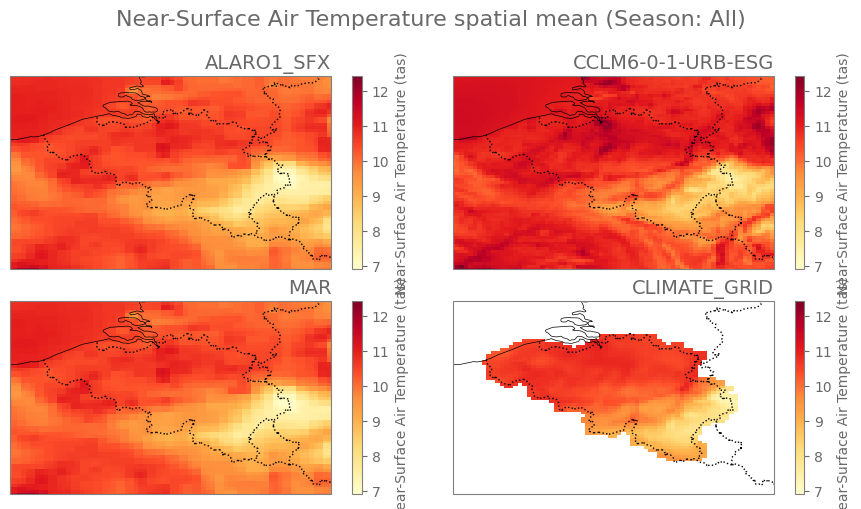

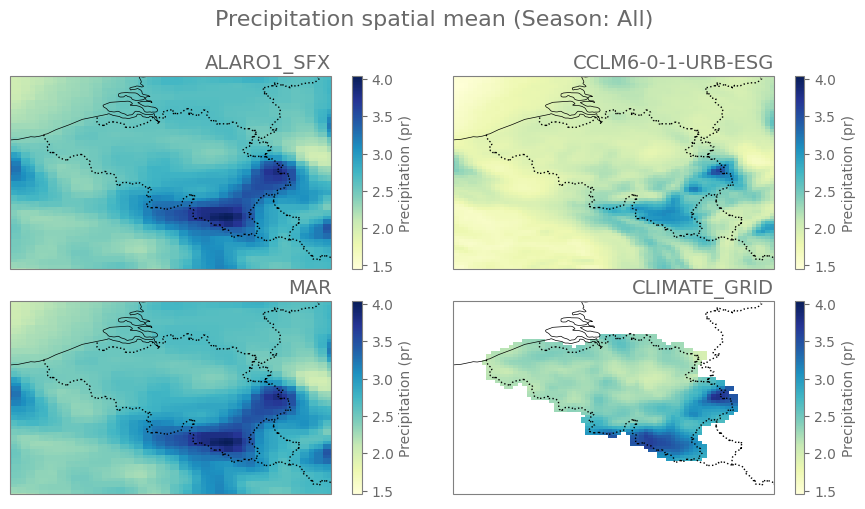

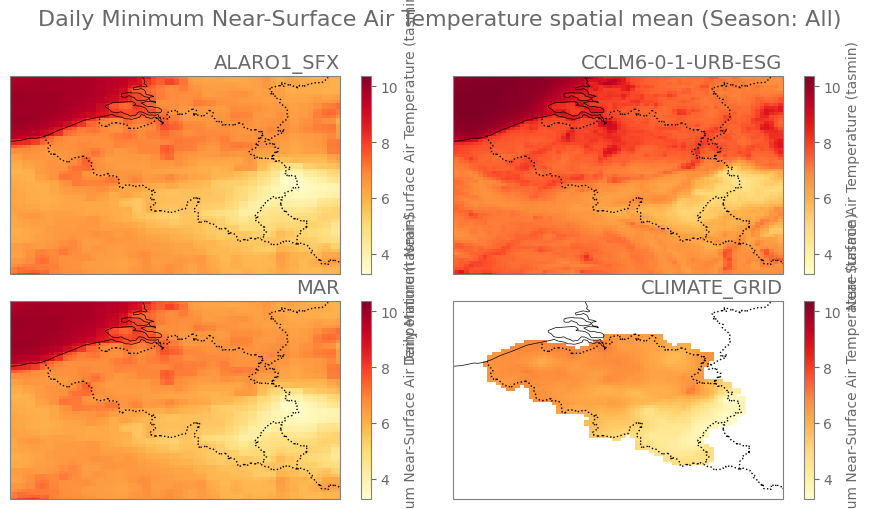

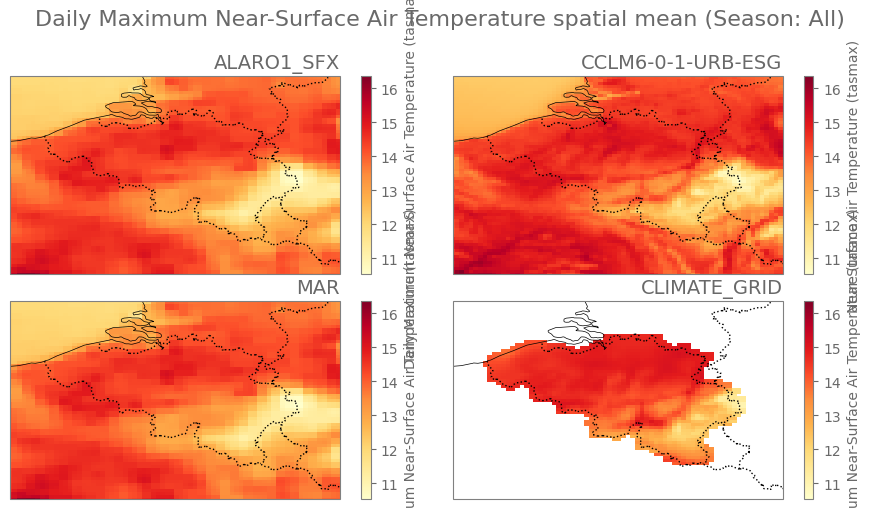

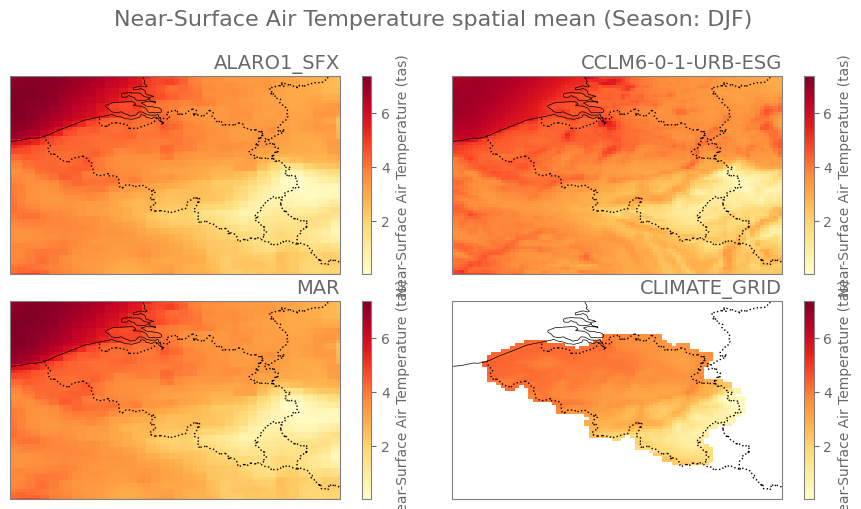

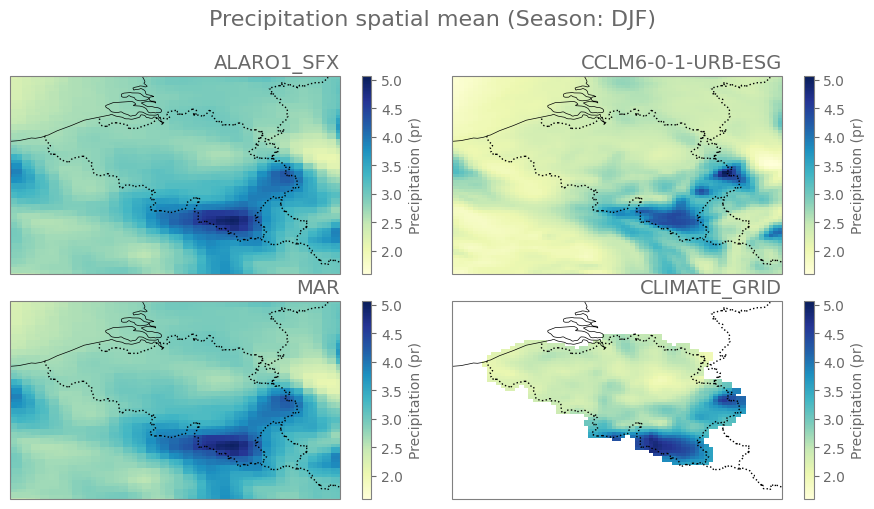

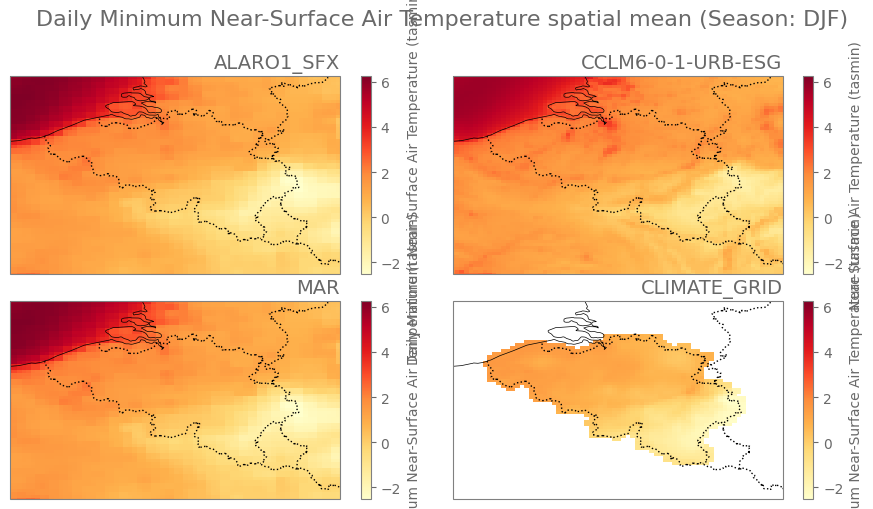

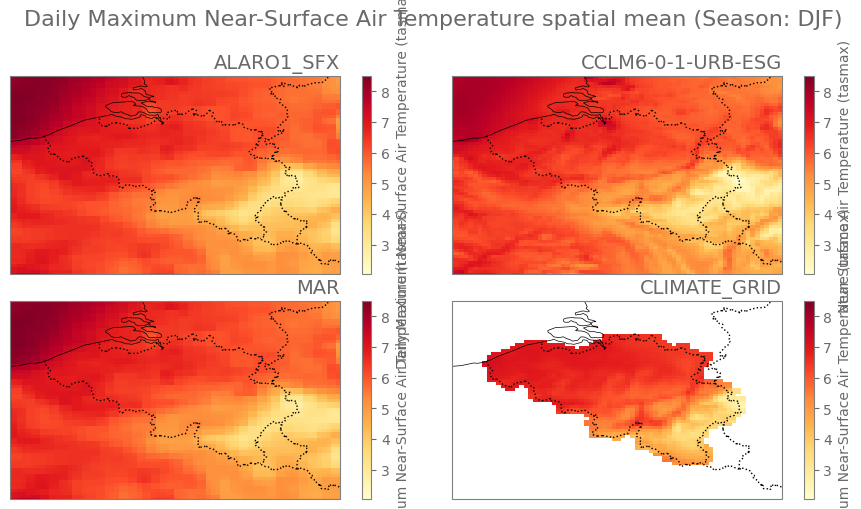

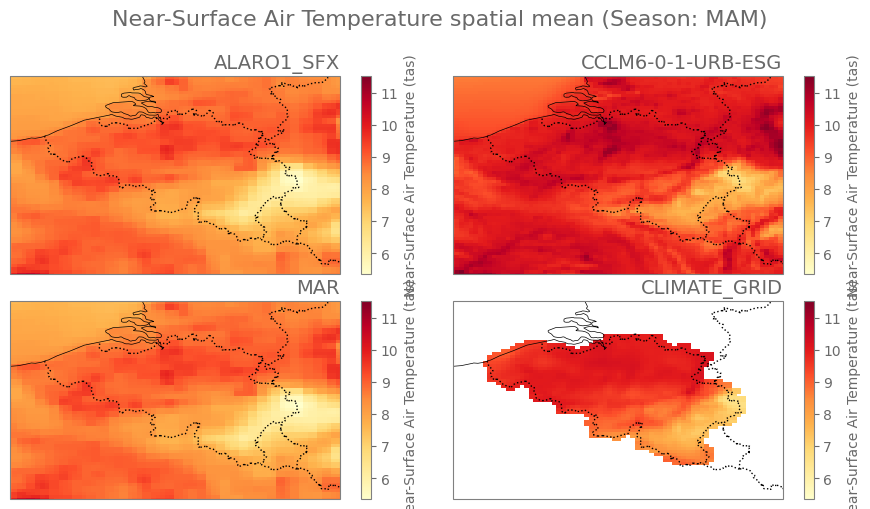

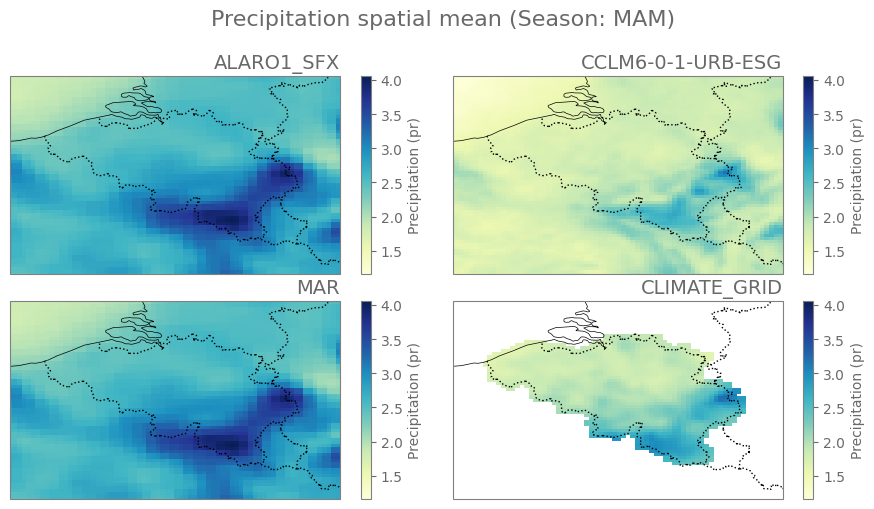

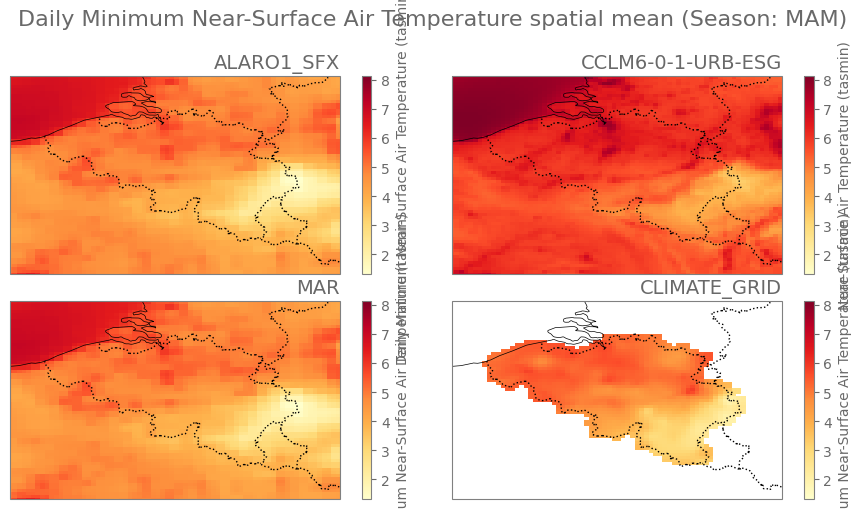

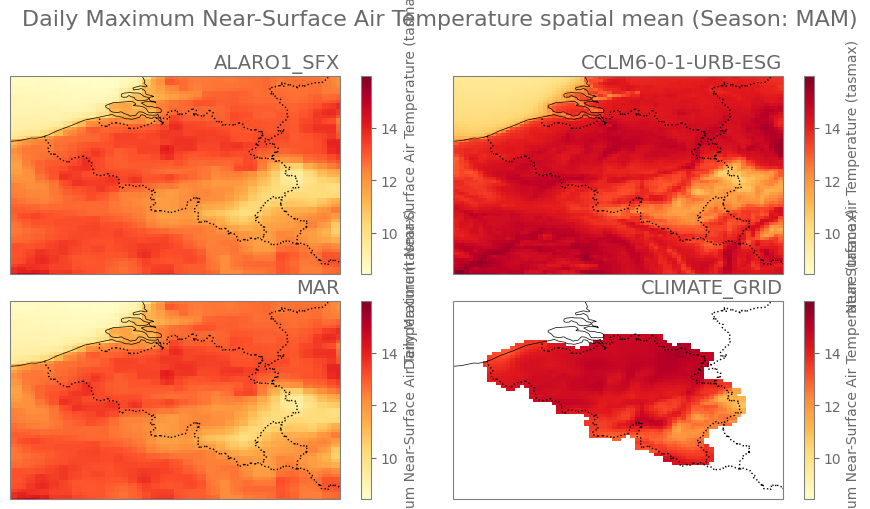

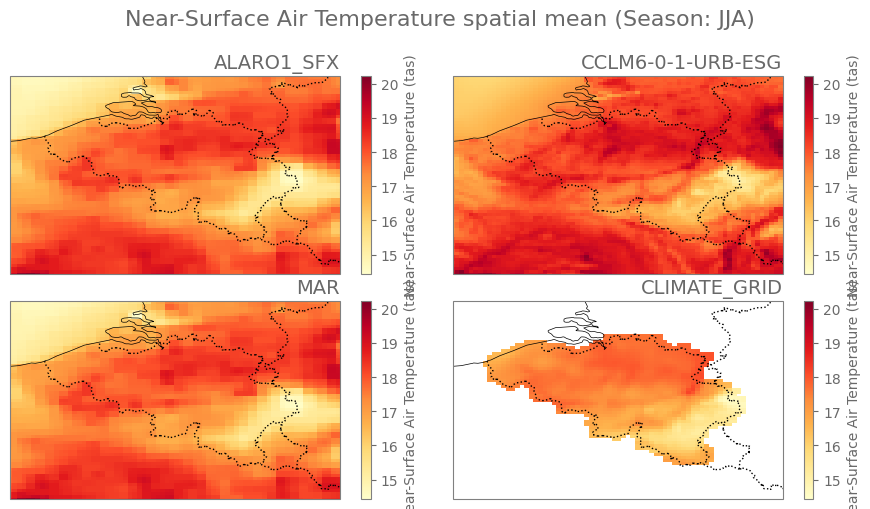

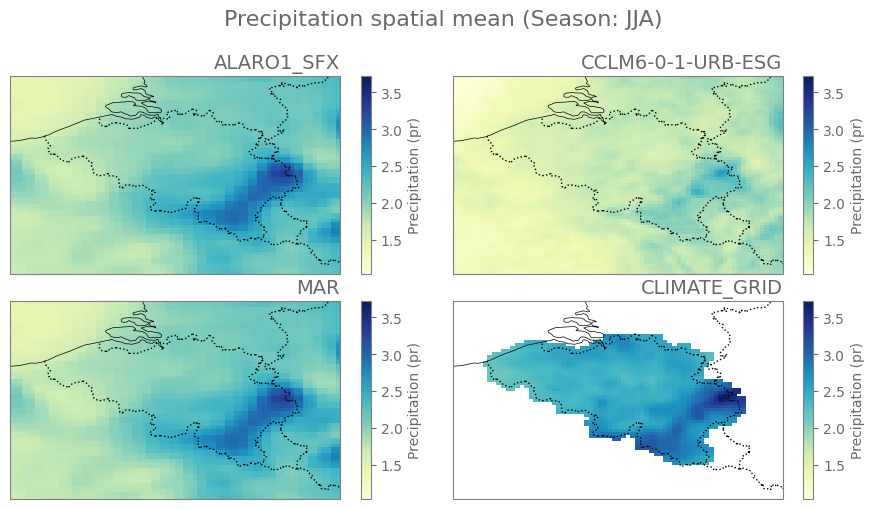

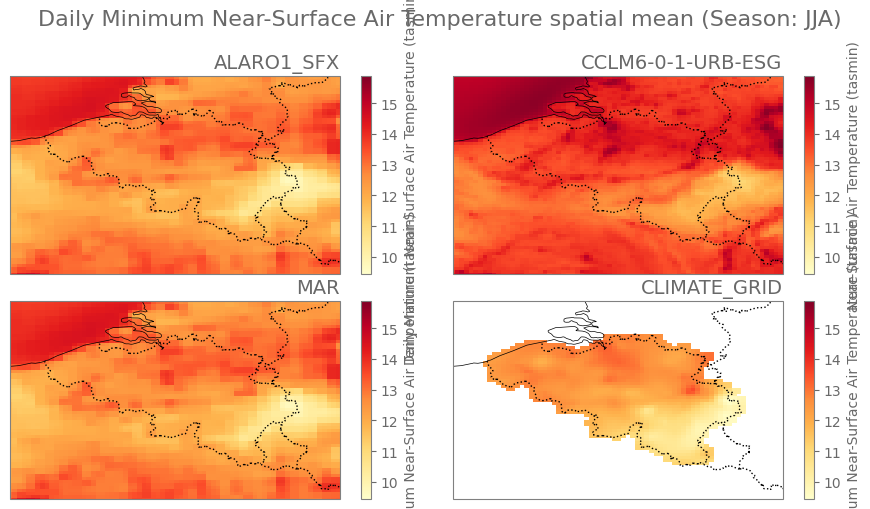

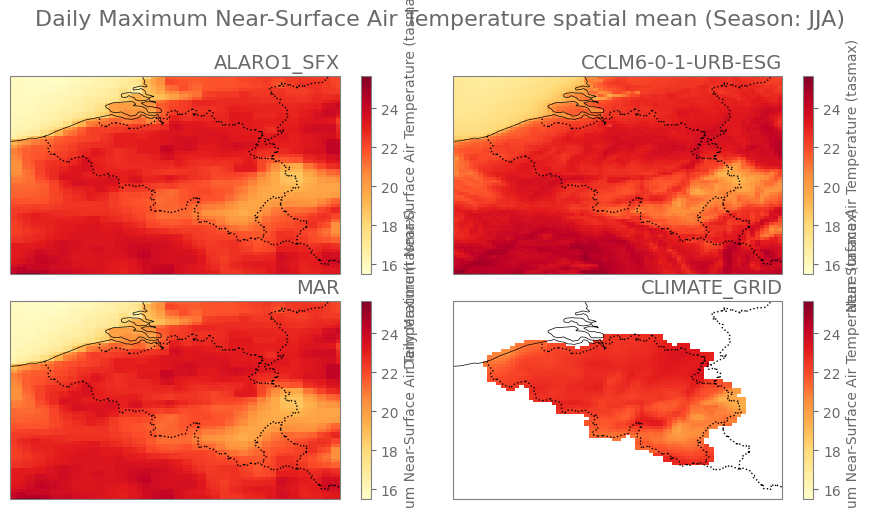

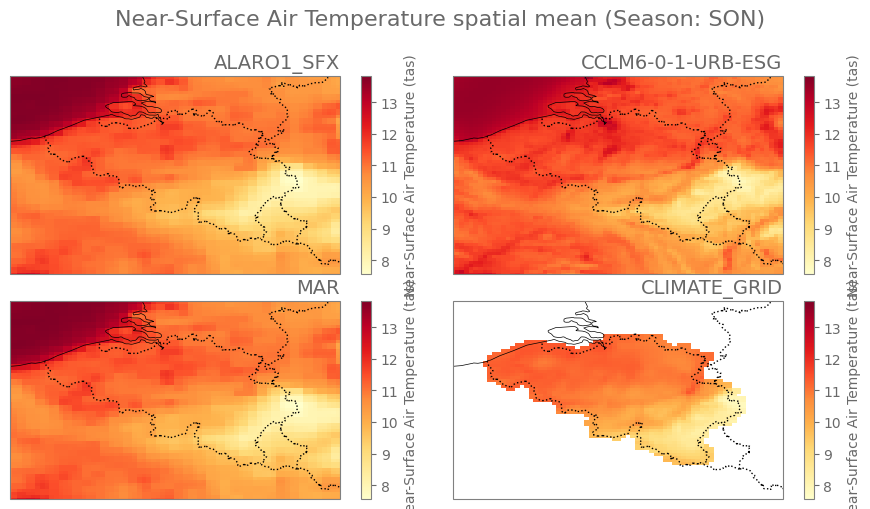

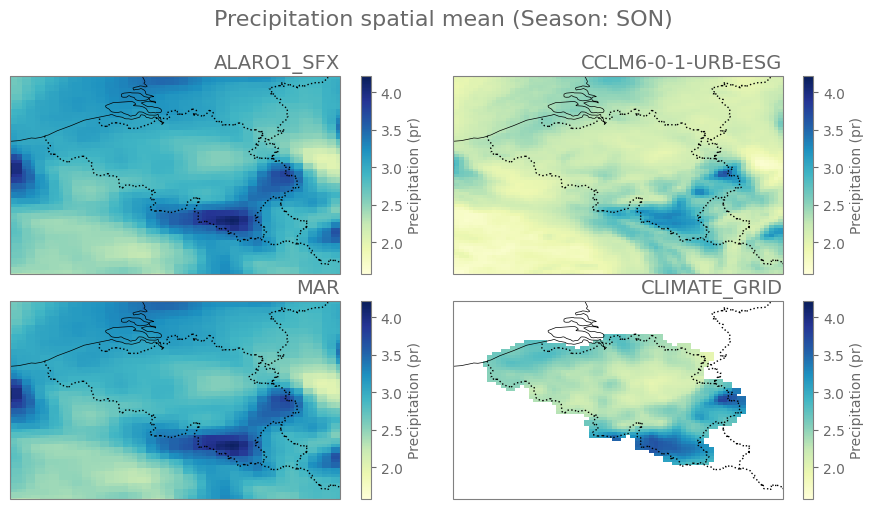

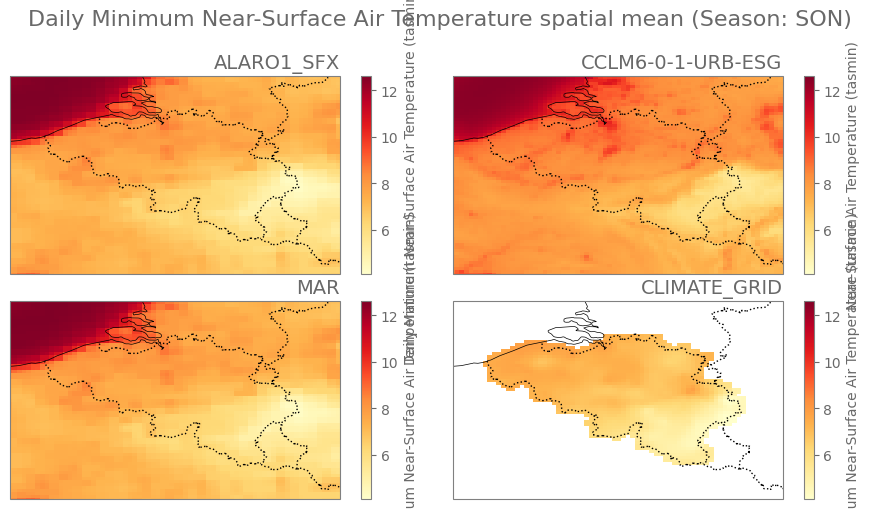

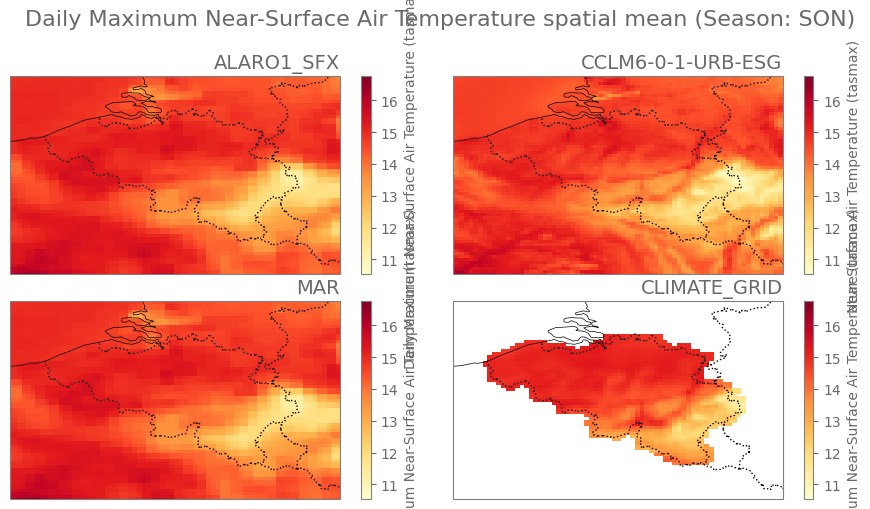

In [19]:
if do_SpatialMean["compute"]:
    #Add other processing steps here (e.g. period selection)
    for season in do_SpatialMean["seasons"]:
        #Select season
        if season != "All":
            dt_s = dt.map_over_subtree(lambda x: x.sel(time=x.time.dt.season == season))
        else:
            dt_s = dt
        #Compute
        with ProgressBar():
            print(f"Computing spatial mean for {season}")
            dt_spatial_mean = SpatialTimeMean(dt_s).compute()

        #Plot
        for var in do_SpatialMean["variables"]:
            fig, axes = plt.subplots(2, 2, figsize=(9, 5), subplot_kw={"projection": ccrs.PlateCarree()})
            axes = axes.flatten()
            
            SpatialTimeMean.plot_type = "facetted"

            SpatialTimeMean.plot_dt(dt_spatial_mean, var=var, axes=axes,shared_cbar="min_max", label="name", cmap=d_cmap_sequential[var])

            for ax in axes:
                _add_features(ax, region='belgium')
            
            fig.suptitle(f'{CORDEX_VARIABLES[var]["long_name"]} spatial mean (Season: {season})',  y=1.01)
            fig.tight_layout()
            plt.savefig(git_dir / f"CORDEX_eval_scripts/plots/{var}_spatial_mean_{season}.png")

### Model2Ref

#### SpatialBias

Computing spatial bias for season All
[########################################] | 100% Completed | 40.51 s
[########################################] | 100% Completed | 14.92 s
[########################################] | 100% Completed | 37.95 s


/dodrio/scratch/projects/2022_200/project_output/RMIB-UGent/vsc46032_kobe/conda_envs/valenspy_xesmf/lib/python3.10/site-packages/cartopy/mpl/feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/dodrio/scratch/projects/2022_200/project_output/RMIB-UGent/vsc46032_kobe/conda_envs/valenspy_xesmf/lib/python3.10/site-packages/cartopy/mpl/feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/dodrio/scratch/projects/2022_200/project_output/RMIB-UGent/vsc46032_kobe/conda_envs/valenspy_xesmf/lib/python3.10/site-packages/cartopy/mpl/feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


Computing spatial bias for season DJF
[########################################] | 100% Completed | 24.17 s
[########################################] | 100% Completed | 15.20 s
[########################################] | 100% Completed | 29.63 s


/dodrio/scratch/projects/2022_200/project_output/RMIB-UGent/vsc46032_kobe/conda_envs/valenspy_xesmf/lib/python3.10/site-packages/cartopy/mpl/feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/dodrio/scratch/projects/2022_200/project_output/RMIB-UGent/vsc46032_kobe/conda_envs/valenspy_xesmf/lib/python3.10/site-packages/cartopy/mpl/feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/dodrio/scratch/projects/2022_200/project_output/RMIB-UGent/vsc46032_kobe/conda_envs/valenspy_xesmf/lib/python3.10/site-packages/cartopy/mpl/feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


Computing spatial bias for season MAM
[########################################] | 100% Completed | 27.76 s
[########################################] | 100% Completed | 12.97 s
[########################################] | 100% Completed | 29.84 s


/dodrio/scratch/projects/2022_200/project_output/RMIB-UGent/vsc46032_kobe/conda_envs/valenspy_xesmf/lib/python3.10/site-packages/cartopy/mpl/feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/dodrio/scratch/projects/2022_200/project_output/RMIB-UGent/vsc46032_kobe/conda_envs/valenspy_xesmf/lib/python3.10/site-packages/cartopy/mpl/feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/dodrio/scratch/projects/2022_200/project_output/RMIB-UGent/vsc46032_kobe/conda_envs/valenspy_xesmf/lib/python3.10/site-packages/cartopy/mpl/feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


Computing spatial bias for season JJA
[########################################] | 100% Completed | 24.25 s
[########################################] | 100% Completed | 18.59 s
[########################################] | 100% Completed | 25.67 s


/dodrio/scratch/projects/2022_200/project_output/RMIB-UGent/vsc46032_kobe/conda_envs/valenspy_xesmf/lib/python3.10/site-packages/cartopy/mpl/feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/dodrio/scratch/projects/2022_200/project_output/RMIB-UGent/vsc46032_kobe/conda_envs/valenspy_xesmf/lib/python3.10/site-packages/cartopy/mpl/feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/dodrio/scratch/projects/2022_200/project_output/RMIB-UGent/vsc46032_kobe/conda_envs/valenspy_xesmf/lib/python3.10/site-packages/cartopy/mpl/feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


Computing spatial bias for season SON
[########################################] | 100% Completed | 25.32 s
[########################################] | 100% Completed | 14.98 s
[########################################] | 100% Completed | 23.60 s


/dodrio/scratch/projects/2022_200/project_output/RMIB-UGent/vsc46032_kobe/conda_envs/valenspy_xesmf/lib/python3.10/site-packages/cartopy/mpl/feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/dodrio/scratch/projects/2022_200/project_output/RMIB-UGent/vsc46032_kobe/conda_envs/valenspy_xesmf/lib/python3.10/site-packages/cartopy/mpl/feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/dodrio/scratch/projects/2022_200/project_output/RMIB-UGent/vsc46032_kobe/conda_envs/valenspy_xesmf/lib/python3.10/site-packages/cartopy/mpl/feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


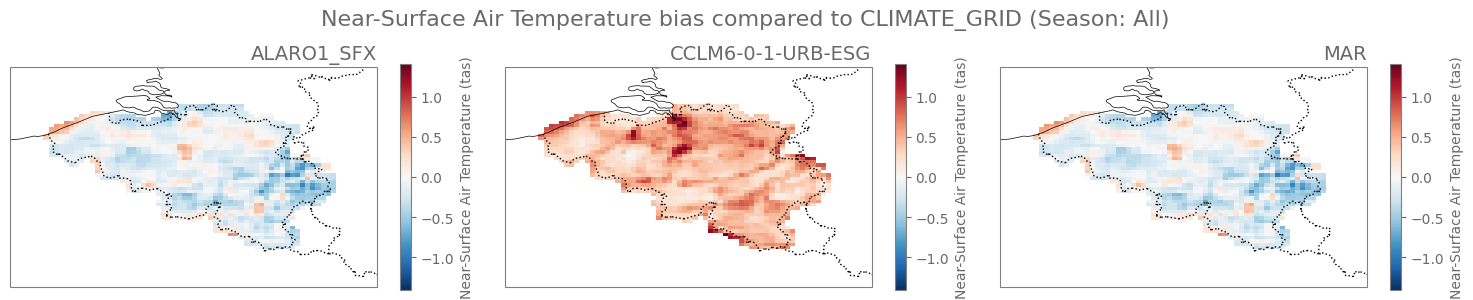

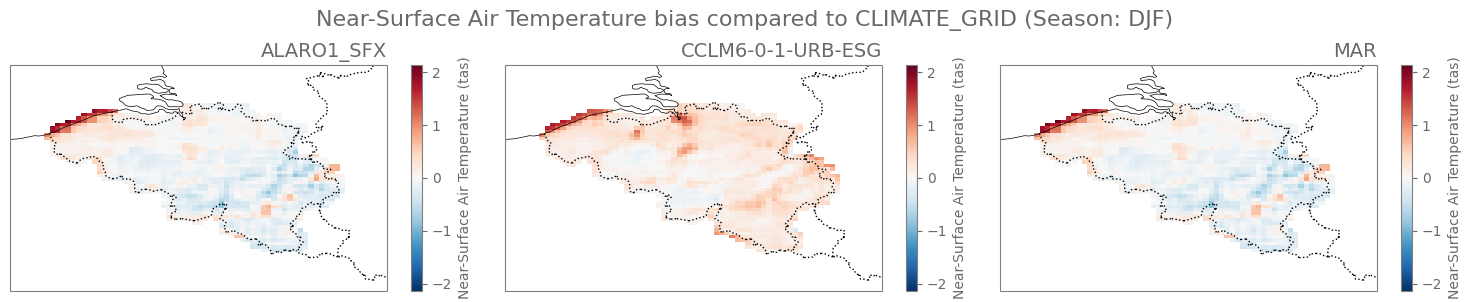

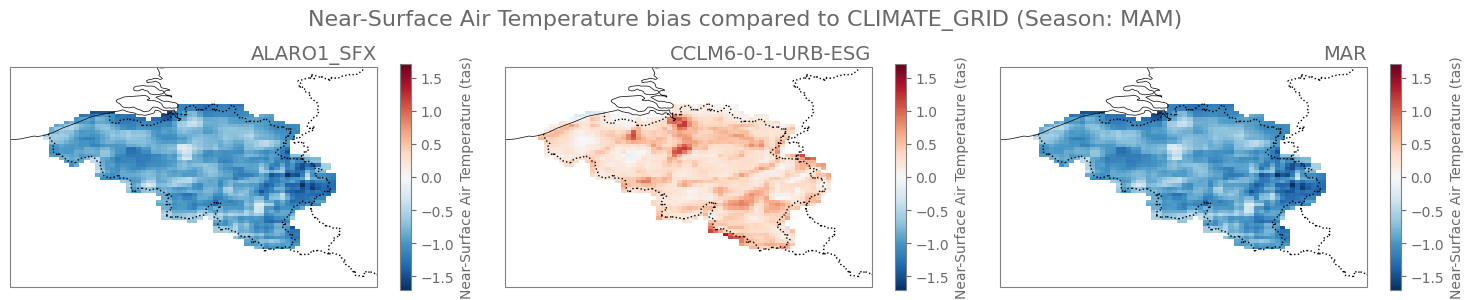

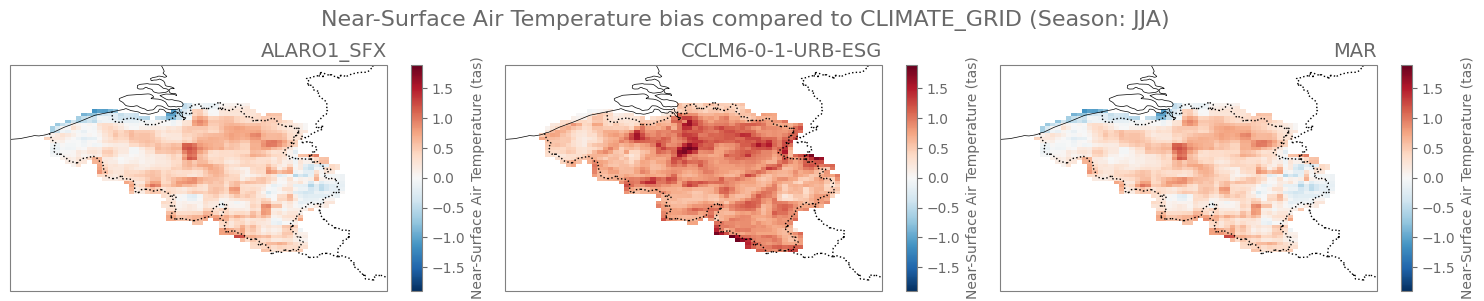

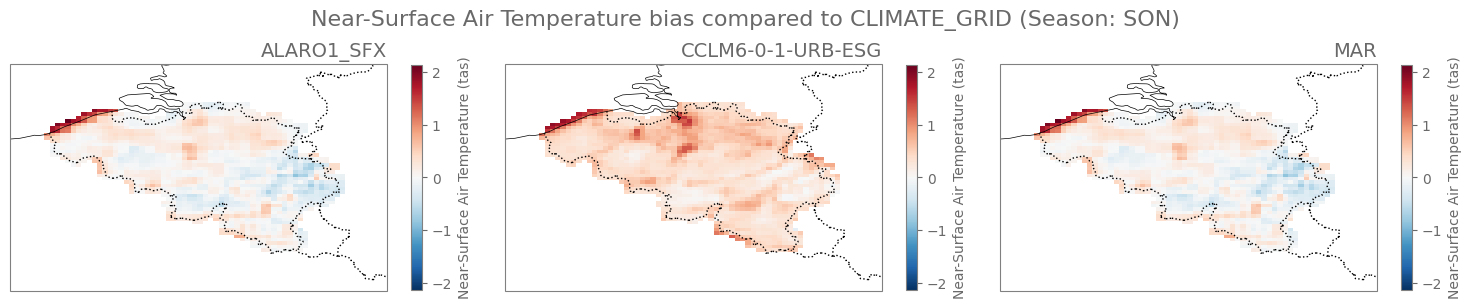

In [ ]:
if do_SpatialBias["compute"]:
    for season in do_SpatialBias["seasons"]:
        if season != "All":
            dt_s = dt.map_over_subtree(lambda x: x.sel(time=x.time.dt.season == season))
        else:
            dt_s = dt

        #Compute    
        with ProgressBar():
            print(f"Computing spatial bias for season {season}")
            ds_ref = dt_s[do_SpatialBias["reference"]].to_dataset()
            dt_spatial_bias = SpatialBias(dt_s.RCM, ref=ds_ref).compute()

        #Plot
        for var in do_SpatialBias["variables"]:
            fig, axes = plt.subplots(1, 3, figsize=(15, 5), subplot_kw={"projection": ccrs.PlateCarree()})
            axes = axes.flatten()
            cbar_kwargs={"shrink": 0.52}

            SpatialBias.plot_dt(dt_spatial_bias, var=var, axes=axes, shared_cbar="abs", label="name", cbar_kwargs=cbar_kwargs, cmap=d_cmap_diverging[var])
            
            for ax in axes:
                _add_features(ax, region='belgium')

            fig.suptitle(f'{CORDEX_VARIABLES[var]["long_name"]} bias compared to CLIMATE_GRID (Season: {season})', y=0.8)
            fig.tight_layout()
            plt.savefig(git_dir / f"CORDEX_eval_scripts/plots/{var}_spatialbias_{season}.png")